# 비대칭 데이터 문제
- https://imbalanced-learn.org/stable/over_sampling.html
-https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import numpy as np
import pandas as pd

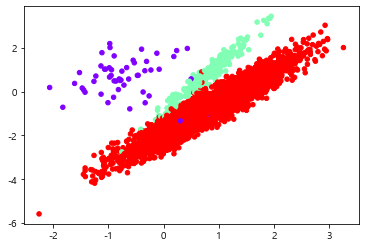

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='rainbow')

## SMOTE
- 가우시안 나이브 등과 같은 알고리즘은 Class weight 파라미터가 없음

In [3]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print(f'normal data distribution: {Counter(y)}')
X_smote, y_smote = SMOTE().fit_resample(X,y)
print(f'SMOTE data distribution: {Counter(y_smote)}')

normal data distribution: Counter({2: 4674, 1: 262, 0: 64})
SMOTE data distribution: Counter({2: 4674, 1: 4674, 0: 4674})


## 원래 데이터로 예측

In [4]:
from sklearn import model_selection, metrics
from imblearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
clf = LinearSVC()
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=11)
model_selection.cross_validate(clf, X, y, scoring='recall_macro', cv=kf)
model_selection.cross_val_score(clf, X, y, scoring='recall_macro', cv=kf)

{'fit_time': array([0.04099441, 0.02807546, 0.02200627]),
 'score_time': array([0.00100064, 0.00100923, 0.00099826]),
 'test_score': array([0.69340238, 0.56378601, 0.59348149])}

array([0.69340238, 0.56378601, 0.59348149])

## Data over-under-combine

In [10]:
from imblearn.over_sampling import *
oversamplers = [RandomOverSampler(random_state=0), ADASYN(random_state=0),
                SMOTE(random_state=42)]
for sampler in oversamplers :
    imba_pipeline= make_pipeline(sampler, clf)
    model_selection.cross_val_score(imba_pipeline, X, y, scoring='recall_macro', cv=kf)

array([0.8378122 , 0.82726718, 0.82383264])

array([0.53418115, 0.5825033 , 0.71177491])

array([0.84221685, 0.83272696, 0.82319038])

In [12]:
borderline_smote = [BorderlineSMOTE(random_state=13), SVMSMOTE(random_state=11)]
for sampler in borderline_smote :
    imba_pipeline= make_pipeline(sampler, clf)
    model_selection.cross_val_score(imba_pipeline, X, y, scoring='recall_macro', cv=kf)

array([0.82447722, 0.86502517, 0.87378737])

array([0.8946434 , 0.91022688, 0.88909526])

In [6]:
from imblearn.under_sampling import *
undersamplers = [RandomUnderSampler(), TomekLinks(), OneSidedSelection()]
for sampler in undersamplers :
    imba_pipeline= make_pipeline(sampler, clf)
    model_selection.cross_val_score(imba_pipeline, X, y, scoring='recall_macro', cv=kf)

array([0.83127029, 0.81136409, 0.82811438])

array([0.71716125, 0.57201646, 0.61246442])

array([0.74588465, 0.81724654, 0.65791897])

In [7]:
from imblearn.combine import *
combinesamplers = [SMOTEENN(random_state=0), SMOTETomek(random_state=4)]
for sampler in combinesamplers :
    imba_pipeline= make_pipeline(sampler, clf)
    model_selection.cross_val_score(imba_pipeline, X, y, scoring='recall_macro', cv=kf)

array([0.86445475, 0.86012321, 0.83558527])

array([0.84414859, 0.83571076, 0.82468899])

# Ensemble of samplers
## Classifier including inner balancing samplers
https://imbalanced-learn.org/stable/ensemble.html
###  Bagging classifier

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=0) 
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0)

for classifier in [bag, brf, rusboost] :
    model_selection.cross_val_score(classifier, X, y, scoring='recall_macro', cv=kf)

array([0.86744119, 0.88333391, 0.85821205])

array([0.88380873, 0.88856932, 0.85341355])

array([0.57121883, 0.50233915, 0.5361327 ])

# 데이터 제거

In [9]:
from sklearn.datasets import fetch_openml
data = fetch_openml(name='CreditCardFraudDetection')
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df['log_Amount'] = np.log(1+df['Amount'])
data = df.sample(frac=0.1, random_state=135).copy()
data.head()
data.shape
data.target.value_counts(normalize=True)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,target,log_Amount
206709,136330.0,2.108286,-0.020359,-2.234273,-0.124080,0.559843,-1.315913,0.631887,-0.385490,0.150628,...,0.519705,-0.091751,-0.379542,0.418822,0.248646,-0.098857,-0.094773,7.70,0.0,2.163323
164567,116819.0,2.080143,-0.075408,-1.359381,0.261263,0.232201,-0.797886,0.233487,-0.330165,0.493154,...,-0.784150,0.233078,-0.636937,-0.191137,0.234986,-0.070648,-0.062794,17.99,0.0,2.943913
16546,27917.0,1.152650,0.204938,0.441832,1.211595,-0.254895,-0.383380,-0.004286,-0.019590,0.085094,...,0.209828,-0.054351,0.058103,0.515330,-0.299402,0.032551,0.022865,21.00,0.0,3.091042
152705,97443.0,-0.389692,0.410148,0.616187,-0.686644,1.040312,-0.322199,0.523625,-0.037453,1.319237,...,0.685267,-0.182303,0.767857,-0.242738,0.009678,0.115370,0.176041,6.60,0.0,2.028148
10646,17920.0,-1.306986,0.183306,3.164803,0.810135,1.529576,2.388322,0.551279,-0.054401,1.675481,...,0.556523,0.146513,-1.128693,-0.633623,-0.454903,-0.826329,-0.826186,4.95,0.0,1.783391


(28481, 32)

0.0    0.998139
1.0    0.001861
Name: target, dtype: float64

In [10]:
X= data[['log_Amount','V1', 'V3', 'V5']]
y= data['target']
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=11)
recall_score = []
for seed in np.random.choice(100, 10):
    np.random.seed(seed)
    recall_score.append(model_selection.cross_val_score(clf, X, y,  #
                                                        scoring='recall', cv=kf).mean())

<Figure size 864x216 with 0 Axes>

<BarContainer object of 10 artists>

10회(5회 교차검증) 평균재현율:0.08905982905982905


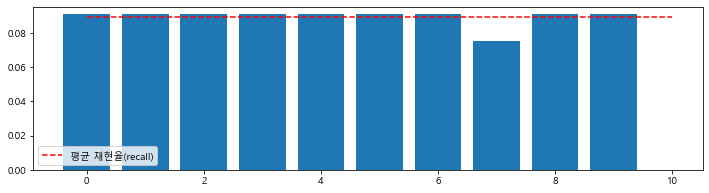

In [11]:
plt.rcParams['font.family']='Malgun Gothic'
plt.figure(figsize=(12,3))
plt.bar(np.arange(10), recall_score)
mean = np.mean(recall_score)
print(f'10회(5회 교차검증) 평균재현율:{mean}')
plt.plot([0, 10], [mean, mean], 'r--', label='평균 재현율(recall)'); plt.legend()

<AxesSubplot:xlabel='target', ylabel='log_Amount'>

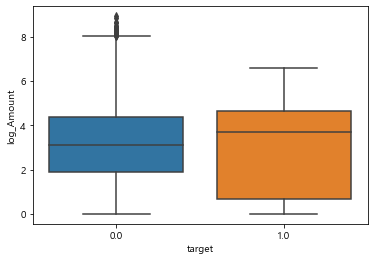

In [12]:
import seaborn as sns
sns.boxplot(x= 'target', y= 'log_Amount', data= data)

In [13]:
max = data[data['target'] == 1]['log_Amount'].max()
data.loc[data['log_Amount'] > max]['target'].value_counts()
print(f'log_Amount 변수값이 {max:.3f}이상이면 항상 적합')
data = data.loc[data['log_Amount'] <= max]
data.shape

0.0    521
Name: target, dtype: int64

log_Amount 변수값이 6.585이상이면 항상 적합


(27960, 32)

In [14]:
data.target.value_counts(normalize=True)

0.0    0.998104
1.0    0.001896
Name: target, dtype: float64

In [15]:
data.target.value_counts(normalize=True)
X= data[['log_Amount','V1', 'V3', 'V5']]
y= data['target']
recall_score = []
for seed in np.random.choice(100, 10):
    np.random.seed(seed)
    recall_score.append(model_selection.cross_val_score(clf, X, y,  #
                                                        scoring='recall', cv=kf).mean())

0.0    0.998104
1.0    0.001896
Name: target, dtype: float64

<Figure size 864x216 with 0 Axes>

<BarContainer object of 10 artists>

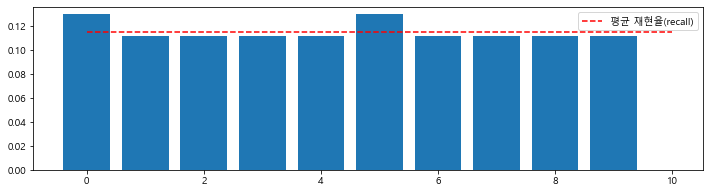

In [16]:
plt.figure(figsize=(12,3))
plt.bar(np.arange(10), recall_score)
mean = np.mean(recall_score)
plt.plot([0, 10], [mean, mean], 'r--', label='평균 재현율(recall)')
plt.legend()

https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival

In [246]:
import math
import scipy.stats as ss
from collections import Counter
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy
def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [247]:
data = fetch_openml(name='mushroom')
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,target
0,5.0,2.0,4.0,1.0,6.0,2.0,0.0,1.0,4.0,0.0,...,7.0,7.0,0.0,2.0,1.0,5.0,2.0,3.0,5.0,p
1,5.0,2.0,9.0,1.0,0.0,2.0,0.0,0.0,4.0,0.0,...,7.0,7.0,0.0,2.0,1.0,5.0,3.0,2.0,1.0,e
2,0.0,2.0,8.0,1.0,3.0,2.0,0.0,0.0,5.0,0.0,...,7.0,7.0,0.0,2.0,1.0,5.0,3.0,2.0,3.0,e
3,5.0,3.0,8.0,1.0,6.0,2.0,0.0,1.0,5.0,0.0,...,7.0,7.0,0.0,2.0,1.0,5.0,2.0,3.0,5.0,p
4,5.0,2.0,3.0,0.0,5.0,2.0,2.0,0.0,4.0,1.0,...,7.0,7.0,0.0,2.0,1.0,1.0,3.0,0.0,1.0,e


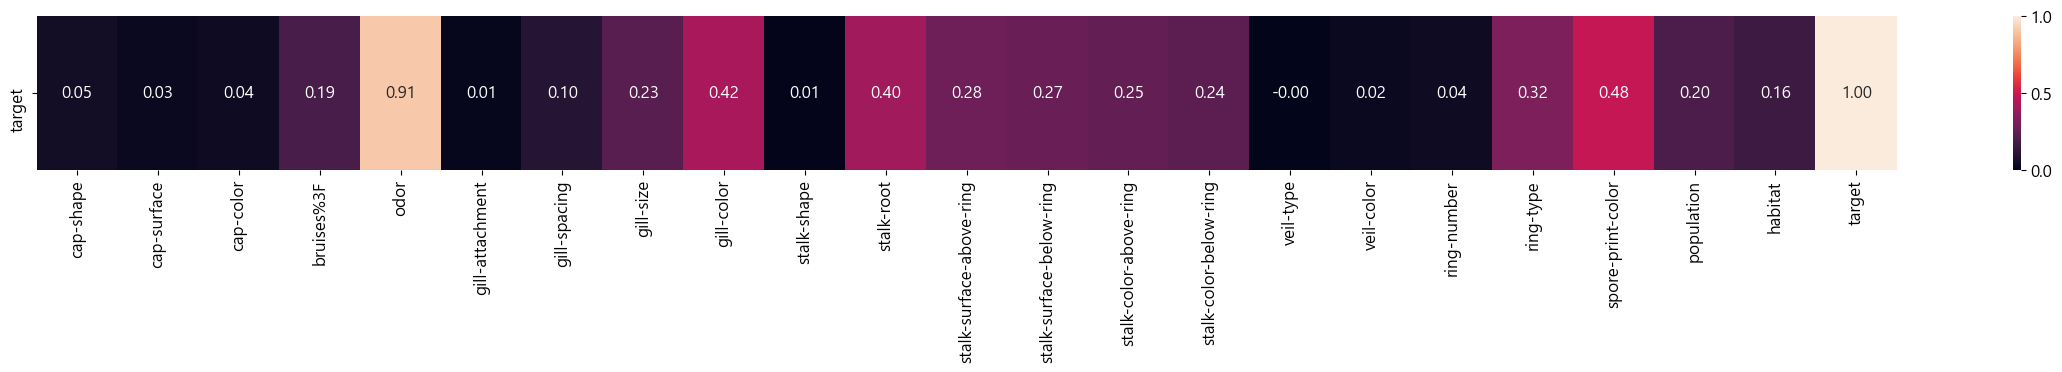

In [254]:
columns = df.columns
theilu = pd.DataFrame(index=['target'], columns= columns)
def cat_corr (df):
    for j in range(0,len(columns)):
        u = theil_u(df['target'].tolist(),df[columns[j]].tolist())
        theilu.loc[:,columns[j]] = u
    theilu.fillna(value=np.nan,inplace=True)
    plt.figure(figsize=(30,2))
    sns.heatmap(theilu,annot=True,fmt='.2f')
    plt.show()

cat_corr(df)

Text(-0.35000000000000003, 10, '0')

Text(0.6500000000000001, 202.0, '192')

Text(1.6500000000000001, 2170.0, '2160')

Text(2.6499999999999995, 10, '0')

Text(3.6499999999999995, 46.0, '36')

Text(4.6499999999999995, 130.0, '120')

Text(5.6499999999999995, 266.0, '256')

Text(6.6499999999999995, 586.0, '576')

Text(7.6499999999999995, 586.0, '576')

Text(0.049999999999999975, 410.0, '400')

Text(1.0499999999999998, 10, '0')

Text(2.05, 10, '0')

Text(3.05, 410.0, '400')

Text(4.05, 10, '0')

Text(5.05, 3418.0, '3408')

Text(6.05, 10, '0')

Text(7.05, 10, '0')

Text(8.049999999999999, 10, '0')

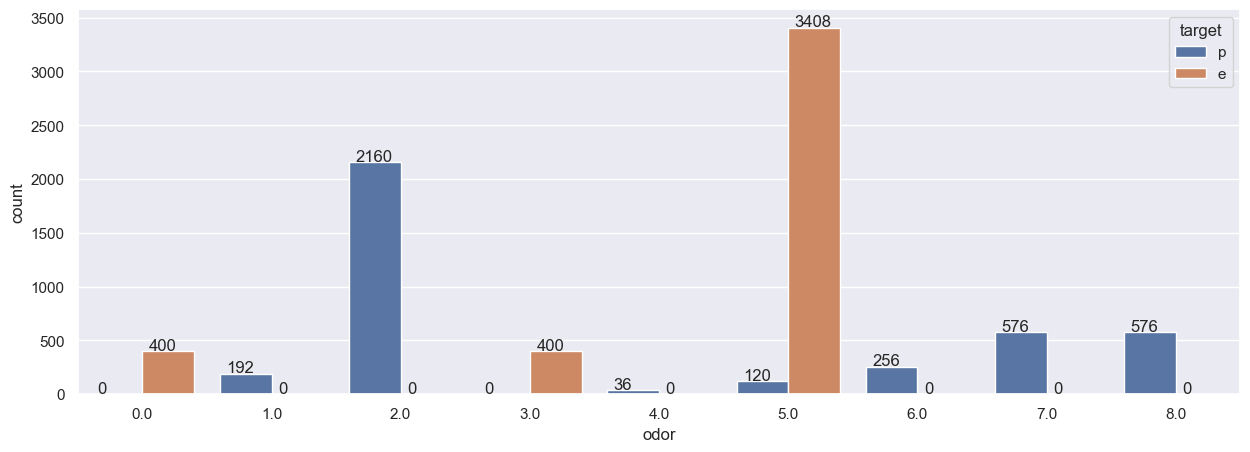

In [258]:
sns.set(rc={'figure.figsize':(15,5)})
ax=sns.countplot(x='odor',hue='target',data=df)
for p in ax.patches:
    patch_height = p.get_height()
    if np.isnan(patch_height):
        patch_height = 0
    ax.annotate('{}'.format(int(patch_height)), (p.get_x()+0.05, patch_height+10))
plt.show()

<Figure size 2000x100 with 0 Axes>

<AxesSubplot:>

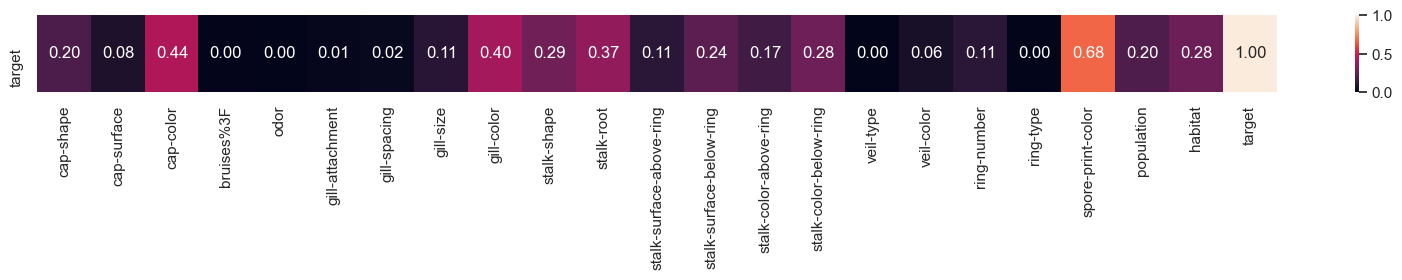

In [261]:
no_odor = df[df['odor'].isin([5.0])]
for j in range(0,len(columns)):
    u = theil_u(no_odor['target'].tolist(),no_odor[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu, annot=True,fmt='.2f')
plt.show()

Text(-0.35000000000000003, 58.0, '48')

Text(0.6500000000000001, 58.0, '48')

Text(1.6500000000000001, 1306.0, '1296')

Text(2.6499999999999995, 1354.0, '1344')

Text(3.6499999999999995, 58.0, '48')

Text(4.6499999999999995, 10, '0')

Text(5.6499999999999995, 586.0, '576')

Text(6.6499999999999995, 58.0, '48')

Text(0.049999999999999975, 10, '0')

Text(1.0499999999999998, 10, '0')

Text(2.05, 10, '0')

Text(3.05, 10, '0')

Text(4.05, 10, '0')

Text(5.05, 82.0, '72')

Text(6.05, 58.0, '48')

Text(7.05, 10, '0')

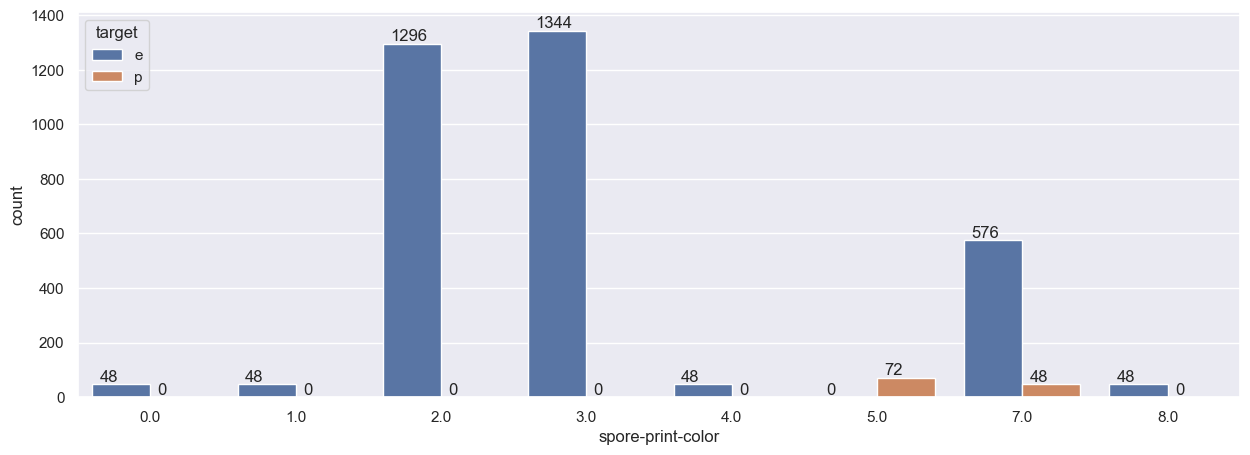

In [264]:
sns.set(rc={'figure.figsize':(15,5)})
ax=sns.countplot(x='spore-print-color',hue='target',data=no_odor)
for p in ax.patches:
    patch_height = p.get_height()
    if np.isnan(patch_height):
        patch_height = 0
    ax.annotate('{}'.format(int(patch_height)), (p.get_x()+0.05, patch_height+10))
plt.show()

In [269]:
no_odor_w = no_odor[no_odor['spore-print-color'].isin([7.0])]
df.shape
no_odor_w.shape
(len(df) - len(no_odor_w)) / len(df)

0.9231905465288035

(8124, 23)

(624, 23)

In [275]:
for col in df.columns:
    df[col] = df[col].astype('category')
    no_odor_w[col] = no_odor_w[col].astype('category')

In [281]:
df.target
df.drop('target', axis=1)

0       p
1       e
2       e
3       p
4       e
       ..
8119    e
8120    e
8121    e
8122    p
8123    e
Name: target, Length: 8124, dtype: category
Categories (2, object): ['e', 'p']

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5.0,2.0,4.0,1.0,6.0,2.0,0.0,1.0,4.0,0.0,...,2.0,7.0,7.0,0.0,2.0,1.0,5.0,2.0,3.0,5.0
1,5.0,2.0,9.0,1.0,0.0,2.0,0.0,0.0,4.0,0.0,...,2.0,7.0,7.0,0.0,2.0,1.0,5.0,3.0,2.0,1.0
2,0.0,2.0,8.0,1.0,3.0,2.0,0.0,0.0,5.0,0.0,...,2.0,7.0,7.0,0.0,2.0,1.0,5.0,3.0,2.0,3.0
3,5.0,3.0,8.0,1.0,6.0,2.0,0.0,1.0,5.0,0.0,...,2.0,7.0,7.0,0.0,2.0,1.0,5.0,2.0,3.0,5.0
4,5.0,2.0,3.0,0.0,5.0,2.0,2.0,0.0,4.0,1.0,...,2.0,7.0,7.0,0.0,2.0,1.0,1.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,3.0,2.0,4.0,0.0,5.0,0.0,0.0,0.0,11.0,0.0,...,2.0,5.0,5.0,0.0,1.0,1.0,5.0,0.0,1.0,2.0
8120,5.0,2.0,4.0,0.0,5.0,0.0,0.0,0.0,11.0,0.0,...,2.0,5.0,5.0,0.0,0.0,1.0,5.0,0.0,4.0,2.0
8121,2.0,2.0,4.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,...,2.0,5.0,5.0,0.0,1.0,1.0,5.0,0.0,1.0,2.0
8122,3.0,3.0,4.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,...,1.0,7.0,7.0,0.0,2.0,1.0,1.0,7.0,4.0,2.0


In [328]:
df.columns

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises%3F', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat', 'target'],
      dtype='object')

In [329]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(random_state=11)
df['target'].value_counts(normalize=True)
X= df.drop(['target', 'stalk-root'], axis=1) 
X.shape
y= df.target.replace({'e':0, 'p':1})
model_selection.cross_val_score(rf, X, y, scoring='recall', cv=kf)

e    0.517971
p    0.482029
Name: target, dtype: float64

(8124, 17)

array([1., 1., 1., 1., 1.])

In [331]:
no_odor_w['target'].value_counts(normalize=True)
X= no_odor_w.drop(['target', 'stalk-root'], axis=1)
X.shape
y= no_odor_w.target.replace({'e':0, 'p':1})
model_selection.cross_val_score(rf, X, y, scoring='recall', cv=kf)

e    0.923077
p    0.076923
Name: target, dtype: float64

(624, 21)

array([1., 1., 1., 1., 1.])

# End